In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import lux
import pandas as pd
import seaborn as sns


| Name                  | Description                                                                         |
|-----------------------|-------------------------------------------------------------------------------------|
| num_frames            | Total number of frames.                                                             |
| num_matches           | Total number matches.                                                               |
| num_switches          | Total number of track switches.                                                     |
| num_false_positives   | Total number of false positives (false-alarms).                                      |
| num_misses            | Total number of misses.                                                             |
| num_detections        | Total number of detected objects including matches and switches.                    |
| num_objects           | Total number of unique object appearances over all frames.                          |
| num_predictions       | Total number of unique prediction appearances over all frames.                      |
| num_unique_objects    | Total number of unique object ids encountered.                                       |
| mostly_tracked        | Number of objects tracked for at least 80 percent of lifespan.                      |
| partially_tracked     | Number of objects tracked between 20 and 80 percent of lifespan.                    |
| mostly_lost           | Number of objects tracked less than 20 percent of lifespan.                         |
| num_fragmentations    | Total number of switches from tracked to not tracked.                               |
| motp                  | Multiple object tracker precision.                                                  |
| mota                  | Multiple object tracker accuracy.                                                   |
| precision             | Number of detected objects over sum of detected and false positives.                |
| recall                | Number of detections over number of objects.                                        |
| idfp                  | ID measures: Number of false positive matches after global min-cost matching.       |
| idfn                  | ID measures: Number of false negatives matches after global min-cost matching.      |
| idtp                  | ID measures: Number of true positives matches after global min-cost matching.       |
| idp                   | ID measures: global min-cost precision.                                             |
| idr                   | ID measures: global min-cost recall.                                                |
| idf1                  | ID measures: global min-cost F1 score.                                              |
| obj_frequencies       | `pd.Series`: Total number of occurrences of individual objects over all frames.     |
| pred_frequencies      | `pd.Series`: Total number of occurrences of individual predictions over all frames.  |
| track_ratios          | `pd.Series`: Ratio of assigned to total appearance count per unique object id.      |
| id_global_assignment  | `dict`: ID measures: Global min-cost assignment for ID measures.                    |
| deta_alpha            | HOTA: Detection Accuracy (DetA) for a given threshold.                              |
| assa_alpha            | HOTA: Association Accuracy (AssA) for a given threshold.                            |
| hota_alpha            | HOTA: Higher Order Tracking Accuracy (HOTA) for a given threshold.                  |


In [4]:
from pathlib import Path

def print_tree(path, prefix='', show_files=False, depth=None, current_depth=0):
    if not isinstance(path, Path):
        path = Path(path)

    if depth is not None and current_depth > depth:
        return

    for item in path.iterdir():
        if item.is_dir():
            print(f'{prefix}├── {item.name}/')
            print_tree(item, prefix + '│   ', show_files, depth, current_depth + 1)
        elif show_files:
            print(f'{prefix}├── {item.name}')

print_tree(run_folder, show_files=False, depth=1)

├── movies/
├── plots/
├── sim_chaotic_snr_-10.0/
│   ├── 00_GT/
│   ├── 00_RES/
│   ├── 01_GT/
│   ├── 01_RES/
│   ├── 02_GT/
│   ├── 02_RES/
│   ├── 03_GT/
│   ├── 03_RES/
│   ├── 04_GT/
│   ├── 04_RES/
│   ├── 05_GT/
│   ├── 05_RES/
│   ├── 06_GT/
│   ├── 06_RES/
│   ├── 07_GT/
│   ├── 07_RES/
│   ├── 08_GT/
│   ├── 08_RES/
│   ├── 09_GT/
│   ├── 09_RES/
│   ├── sim_chaotic_snr_-10.0/
├── sim_chaotic_snr_-15.0/
│   ├── 00_GT/
│   ├── 00_RES/
│   ├── 01_GT/
│   ├── 01_RES/
│   ├── 02_GT/
│   ├── 02_RES/
│   ├── 03_GT/
│   ├── 03_RES/
│   ├── 04_GT/
│   ├── 04_RES/
│   ├── 05_GT/
│   ├── 05_RES/
│   ├── 06_GT/
│   ├── 06_RES/
│   ├── 07_GT/
│   ├── 07_RES/
│   ├── 08_GT/
│   ├── 08_RES/
│   ├── 09_GT/
│   ├── 09_RES/
│   ├── sim_chaotic_snr_-15.0/
├── sim_chaotic_snr_-5.0/
│   ├── 00_GT/
│   ├── 00_RES/
│   ├── 01_GT/
│   ├── 01_RES/
│   ├── 02_GT/
│   ├── 02_RES/
│   ├── 03_GT/
│   ├── 03_RES/
│   ├── 04_GT/
│   ├── 04_RES/
│   ├── 05_GT/
│   ├── 05_RES/
│   ├── 06_GT/
│   ├── 06_RES

In [2]:
run_folder = 'evaluation_arcospx_run24/'

In [7]:
import os

In [5]:
import napari
viewer = napari.Viewer()


In [8]:
folders = os.listdir(run_folder)
folders_full = [os.path.join(run_folder, f) for f in folders]
folders_full = [f for f in folders_full if os.path.isdir(f)]
print(folders_full)

['evaluation_arcospx_run24/movies', 'evaluation_arcospx_run24/plots', 'evaluation_arcospx_run24/sim_chaotic_snr_-10.0', 'evaluation_arcospx_run24/sim_chaotic_snr_-15.0', 'evaluation_arcospx_run24/sim_chaotic_snr_-5.0', 'evaluation_arcospx_run24/sim_chaotic_snr_0.0', 'evaluation_arcospx_run24/sim_chaotic_snr_25.0', 'evaluation_arcospx_run24/sim_chaotic_snr_inf', 'evaluation_arcospx_run24/sim_circles_snr_-10.0', 'evaluation_arcospx_run24/sim_circles_snr_-15.0', 'evaluation_arcospx_run24/sim_circles_snr_-5.0', 'evaluation_arcospx_run24/sim_circles_snr_0.0', 'evaluation_arcospx_run24/sim_circles_snr_25.0', 'evaluation_arcospx_run24/sim_circles_snr_inf', 'evaluation_arcospx_run24/sim_directional_snr_-10.0', 'evaluation_arcospx_run24/sim_directional_snr_-15.0', 'evaluation_arcospx_run24/sim_directional_snr_-5.0', 'evaluation_arcospx_run24/sim_directional_snr_0.0', 'evaluation_arcospx_run24/sim_directional_snr_25.0', 'evaluation_arcospx_run24/sim_directional_snr_inf', 'evaluation_arcospx_run2

In [9]:
from skimage import io
import dask.array as da
from dask import delayed
import os
import numpy as np

selected_folder = 'evaluation_arcospx_run24/sim_target_pattern_snr_inf'

delayed_read = delayed(io.imread)

path  = f"{selected_folder}/00_RES"
files = os.listdir(path)
files = [f for f in files if f.endswith('.tif')]
files.sort()

# load all images as dask arrays
lazy_values = [delayed_read(os.path.join(path, f)) for f in files]
arrays_res = np.stack([da.from_delayed(lazy_value, shape=(512, 512), dtype='uint16') for lazy_value in lazy_values])

path  = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{selected_folder}/00_GT/TRA"
files = os.listdir(path)
files = [f for f in files if f.endswith('.tif')]
files.sort()

# load all images as dask arrays
lazy_values = [delayed_read(os.path.join(path, f)) for f in files]
arrays_tra = np.stack([da.from_delayed(lazy_value, shape=(512, 512), dtype='uint16') for lazy_value in lazy_values])



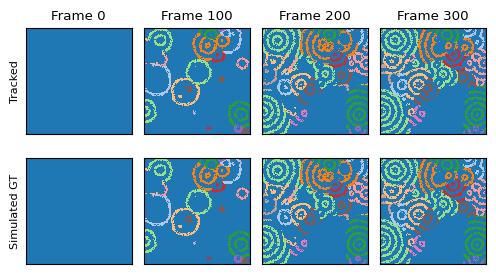

In [10]:
# plot 4 example frames with matplotlib
plt.rcParams.update({'svg.fonttype': 'none'})
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(2, 4, figsize=(5, 3))
frames_to_show = np.arange(0, 400, 100)
max_val = arrays_res[-1].max()
for i, frame in enumerate(frames_to_show):
    axs[0, i].imshow(arrays_res[frame], cmap='tab20', interpolation='nearest', vmin=0, vmax=max_val)
    axs[0, i].set_title(f'Frame {frame}')
    axs[0, i].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    axs[1, i].imshow(arrays_tra[frame], cmap='tab20', interpolation='nearest', vmin=0, vmax=max_val)
    axs[1, i].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    
    if i == 0:
        axs[0, i].set_ylabel('Tracked')
        axs[1, i].set_ylabel('Simulated GT')
plt.tight_layout()
# plt.savefig(f'{run_folder}/plots/example_frames_directional.svg', dpi=300)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import matplotlib
import matplotlib.animation as animation
from IPython.display import display, clear_output

# Update the plot parameters
plt.rcParams.update({'svg.fonttype': 'none'})
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.size': 16})

# SET BLACK THEME
plt.style.use('dark_background')

# Define simulation types and SNR levels
sim_types = ['sim_circles', 'sim_directional', 'sim_target_pattern', 'sim_chaotic']
snr_levels = ['inf', '25.0', '0.0', '-5.0', '-10.0', '-15.0']

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import matplotlib
import matplotlib.animation as animation
from IPython.display import display, clear_output

def create_animation(sim_type, run_folder):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()
    
    arrays_all = []
    img_objects = []
    
    # Load data for each SNR level
    for i, snr in enumerate(snr_levels):
        raw_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_{snr}/00_GT/RAW"
        raw_files = sorted([f for f in os.listdir(raw_path) if f.endswith('.tif')])
        # Load and downsample temporally
        arrays = np.stack([io.imread(os.path.join(raw_path, f)) for f in raw_files[::3]])
        
        # Normalize each dataset individually
        arrays_norm = (arrays - arrays.min()) / (arrays.max() - arrays.min())
        arrays_all.append(arrays_norm)
    
    # Initialize plots
    for i, snr in enumerate(snr_levels):
        img = axs[i].imshow(arrays_all[i][0], cmap='viridis',
                          interpolation='nearest', vmin=0, vmax=1)
        img_objects.append(img)
        axs[i].set_title(f'SNR: {snr}')
        
        # Disable ticks
        axs[i].tick_params(axis='both', which='both', bottom=False, top=False,
                          labelbottom=False, right=False, left=False, labelleft=False)
        for axis in ['top', 'bottom', 'left', 'right']:
            axs[i].spines[axis].set_linewidth(2)
    
    # Add colorbar
    plt.colorbar(img_objects[0], ax=axs, orientation='horizontal',
                label='Normalized Intensity', fraction=0.046, pad=0.04)
    
    # plt.tight_layout()
    
    # Update function for animation
    def update(frame):
        for i in range(len(snr_levels)):
            img_objects[i].set_data(arrays_all[i][frame])
        fig.suptitle(f'{sim_type} - Frame {str(frame).zfill(3)}', y=1.02)
        clear_output(wait=True)
        display(f'Frame {frame} / {len(arrays_all[0])}')
        return img_objects + [fig.texts[0]]
    
    # Create and save animation
    ani = animation.FuncAnimation(fig, update, frames=len(arrays_all[0]), blit=True)
    
    os.makedirs(os.path.join(run_folder, 'movies'), exist_ok=True)
    output_path = os.path.join(run_folder, 'movies', f'{sim_type}_combined_raw_normalized.mp4')
    
    writer = animation.FFMpegWriter(
        fps=30,
        codec='h264',
        bitrate=2000,
        extra_args=['-preset', 'slow', '-crf', '22']
    )
    
    ani.save(output_path, writer=writer, dpi=150)
    plt.close(fig)

# Run the animation
run_folder = "evaluation_arcospx_run24"
for sim_type in sim_types:
    create_animation(sim_type, run_folder)
    print(f"Completed animation for {sim_type}")

'Frame 166 / 167'

Completed animation for sim_chaotic


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import matplotlib
import matplotlib.animation as animation
from IPython.display import display, clear_output
import random

# Update the plot parameters
plt.rcParams.update({'svg.fonttype': 'none'})
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.size': 16})
# Set black theme
plt.style.use('dark_background')

def generate_random_color():
    return (random.random(), random.random(), random.random())

def create_combined_animation(sim_types, run_folder):
    # Create figure with 3 rows (RAW/GT/RES) and 4 columns (sim types)
    fig, axs = plt.subplots(3, len(sim_types), figsize=(20, 12))
    
    raw_arrays_all = []
    tra_arrays_all = []
    res_arrays_all = []
    img_objects_raw = []
    img_objects_tra = []
    img_objects_res = []
    color_maps = {}
    
    # Load data for all simulation types
    for i, sim_type in enumerate(sim_types):
        # Load RAW data
        raw_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_inf/00_GT/RAW"
        raw_files = sorted([f for f in os.listdir(raw_path) if f.endswith('.tif')])
        raw_arrays = np.stack([io.imread(os.path.join(raw_path, f)) for f in raw_files[::3]])
        raw_norm = (raw_arrays - raw_arrays.min()) / (raw_arrays.max() - raw_arrays.min())
        raw_arrays_all.append(raw_norm)
        
        # Load TRA (Ground Truth) data
        tra_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_inf/00_GT/TRA"
        tra_files = sorted([f for f in os.listdir(tra_path) if f.endswith('.tif')])
        tra_arrays = np.stack([io.imread(os.path.join(tra_path, f)) for f in tra_files[::3]])
        tra_arrays_all.append(tra_arrays)
        
        # Load RES (Results) data
        res_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_inf/00_RES"
        res_files = sorted([f for f in os.listdir(res_path) if f.endswith('.tif')])
        res_arrays = np.stack([io.imread(os.path.join(res_path, f)) for f in res_files[::3]])
        res_arrays_all.append(res_arrays)
        
        # Generate colors for new IDs
        for arrays in [tra_arrays, res_arrays]:
            unique_ids = np.unique(arrays)
            unique_ids = unique_ids[unique_ids != 0]
            for id_num in unique_ids:
                if id_num not in color_maps:
                    color_maps[id_num] = generate_random_color()
    
    # Initialize plots
    for i, sim_type in enumerate(sim_types):
        # RAW data plot
        img_raw = axs[0, i].imshow(raw_arrays_all[i][0], cmap='viridis', 
                                  interpolation='nearest', vmin=0, vmax=1)
        img_objects_raw.append(img_raw)
        
        # TRA (Ground Truth) data plot
        initial_frame_tra = np.zeros((*tra_arrays_all[i][0].shape, 4))
        initial_frame_tra[..., 3] = (tra_arrays_all[i][0] > 0).astype(float)
        for id_num in np.unique(tra_arrays_all[i][0]):
            if id_num > 0:
                mask = tra_arrays_all[i][0] == id_num
                initial_frame_tra[mask, :3] = color_maps[id_num]
        
        img_tra = axs[1, i].imshow(initial_frame_tra, interpolation='nearest')
        img_objects_tra.append(img_tra)
        
        # RES (Results) data plot
        initial_frame_res = np.zeros((*res_arrays_all[i][0].shape, 4))
        initial_frame_res[..., 3] = (res_arrays_all[i][0] > 0).astype(float)
        for id_num in np.unique(res_arrays_all[i][0]):
            if id_num > 0:
                mask = res_arrays_all[i][0] == id_num
                initial_frame_res[mask, :3] = color_maps[id_num]
        
        img_res = axs[2, i].imshow(initial_frame_res, interpolation='nearest')
        img_objects_res.append(img_res)
        
        # Set column titles (simulation types)
        axs[0, i].set_title(sim_type)
        
        # Disable ticks for all plots
        for ax in axs[:, i]:
            ax.tick_params(axis='both', which='both', bottom=False, top=False,
                          labelbottom=False, right=False, left=False, labelleft=False)
            for axis in ['top', 'bottom', 'left', 'right']:
                ax.spines[axis].set_linewidth(2)
    
    # Set row labels
    row_labels = ['Raw Data', 'Ground Truth', 'Tracking Result']
    for i, label in enumerate(row_labels):
        axs[i, 0].set_ylabel(label, rotation=90, labelpad=10)
    
    # # Add colorbar for RAW data
    # plt.colorbar(img_objects_raw[0], ax=axs[0, :].ravel().tolist(), 
    #             orientation='horizontal', label='Normalized Intensity',
    #             fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    # Update function for animation
    def update(frame):
        all_objects = []
        for i in range(len(sim_types)):
            # Update RAW data
            img_objects_raw[i].set_array(raw_arrays_all[i][frame])
            all_objects.append(img_objects_raw[i])
            
            # Update TRA (Ground Truth) data
            current_frame_tra = np.zeros((*tra_arrays_all[i][frame].shape, 4))
            current_frame_tra[..., 3] = (tra_arrays_all[i][frame] > 0).astype(float)
            for id_num in np.unique(tra_arrays_all[i][frame]):
                if id_num > 0:
                    mask = tra_arrays_all[i][frame] == id_num
                    current_frame_tra[mask, :3] = color_maps[id_num]
            img_objects_tra[i].set_array(current_frame_tra)
            all_objects.append(img_objects_tra[i])
            
            # Update RES (Results) data
            current_frame_res = np.zeros((*res_arrays_all[i][frame].shape, 4))
            current_frame_res[..., 3] = (res_arrays_all[i][frame] > 0).astype(float)
            for id_num in np.unique(res_arrays_all[i][frame]):
                if id_num > 0:
                    mask = res_arrays_all[i][frame] == id_num
                    current_frame_res[mask, :3] = color_maps[id_num]
            img_objects_res[i].set_array(current_frame_res)
            all_objects.append(img_objects_res[i])
        
        fig.suptitle(f'Frame {str(frame).zfill(3)}', y=1.02)
        clear_output(wait=True)
        display(f'Frame {frame} / {len(raw_arrays_all[0])}')
        return all_objects + [fig.texts[0]]
    
    # Create and save animation
    ani = animation.FuncAnimation(fig, update, frames=len(raw_arrays_all[0]), blit=True)
    
    os.makedirs(os.path.join(run_folder, 'movies'), exist_ok=True)
    output_path = os.path.join(run_folder, 'movies', f'all_simulations_comparison.mp4')
    
    writer = animation.FFMpegWriter(
        fps=30,
        codec='h264',
        bitrate=2000,
        extra_args=['-preset', 'slow', '-crf', '22']
    )
    
    ani.save(output_path, writer=writer, dpi=150)
    plt.close(fig)

# Run the combined animation
run_folder = "evaluation_arcospx_run24"
create_combined_animation(sim_types, run_folder)
print("Completed combined animation")

'Frame 163 / 164'

Completed combined animation


Completed single frame plot for frame 150


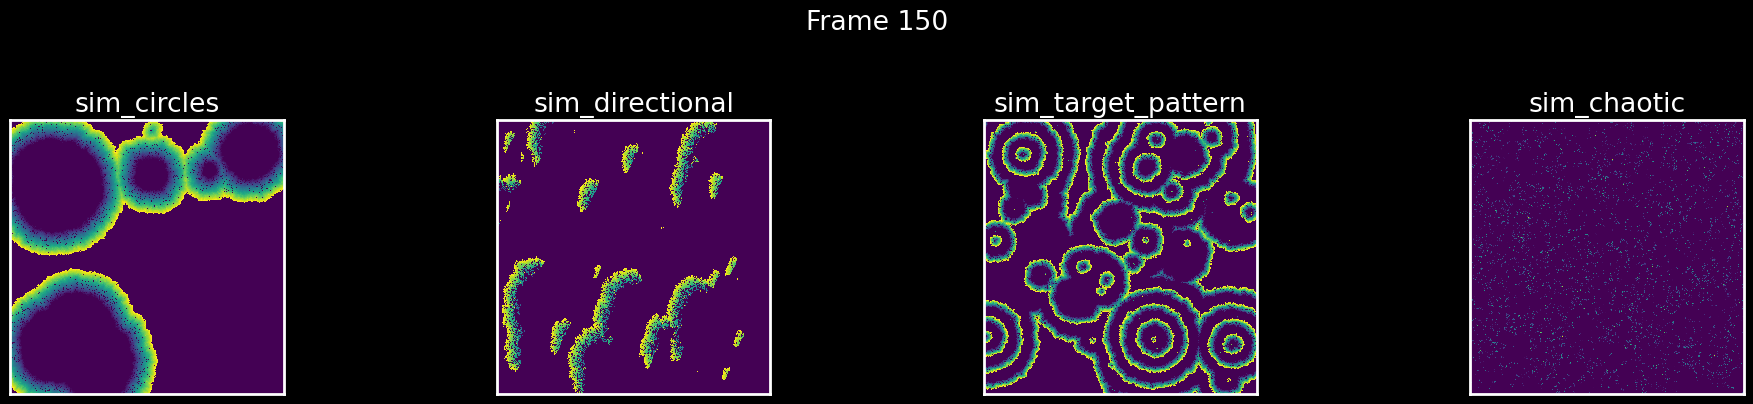

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import random

# Define simulation types
sim_types = ['sim_circles', 'sim_directional', 'sim_target_pattern', 'sim_chaotic']

np.random.seed(42)

def generate_random_color():
    return (random.random(), random.random(), random.random())

def create_single_frame_plot(sim_types, run_folder, frame_num=150):
    # Create figure with 1 row and len(sim_types) columns
    fig, axs = plt.subplots(1, len(sim_types), figsize=(20, 4))
    
    # Set black theme
    plt.style.use('dark_background')
    
    # Update plot parameters
    plt.rcParams.update({
        'svg.fonttype': 'none',
        'font.style': 'normal',
        'font.size': 16
    })
    
    # Load and plot specific frame for each simulation type
    for i, sim_type in enumerate(sim_types):
        # Load only frame 150 from RAW data
        raw_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_inf/00_GT/RAW"
        raw_files = sorted([f for f in os.listdir(raw_path) if f.endswith('.tif')])
        frame_file = raw_files[frame_num]
        raw_array = io.imread(os.path.join(raw_path, frame_file))
        
        # Normalize RAW data
        raw_norm = (raw_array - raw_array.min()) / (raw_array.max() - raw_array.min())
        
        # Plot RAW data
        img = axs[i].imshow(raw_norm, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        
        # Set title and disable ticks
        axs[i].set_title(sim_type)
        axs[i].tick_params(axis='both', which='both', bottom=False, top=False,
                          labelbottom=False, right=False, left=False, labelleft=False)
        
        # Set spine width
        for spine in axs[i].spines.values():
            spine.set_linewidth(2)
    
    plt.suptitle(f'Frame {str(frame_num).zfill(3)}', y=1.02)
    plt.tight_layout()
    
    # Save the plot
    os.makedirs(os.path.join(run_folder, 'plots'), exist_ok=True)
    output_path = os.path.join(run_folder, 'plots', f'frame_{frame_num}_comparison.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    # plt.close(fig)

# Run the single frame plot
run_folder = "evaluation_arcospx_run24"
create_single_frame_plot(sim_types, run_folder)
print(f"Completed single frame plot for frame 150")

Completed noise level plot for sim_circles, frame 150


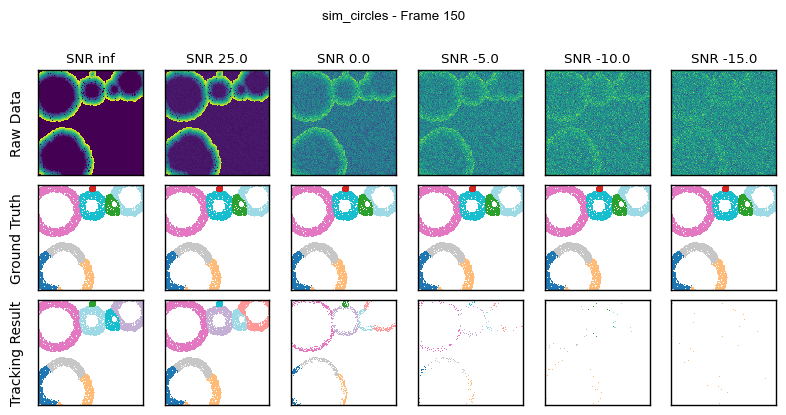

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

# set default theme
plt.style.use('default')

# Define noise levels
snr_levels = ['inf', '25.0', '0.0', '-5.0', '-10.0', '-15.0']
sim_type = 'sim_circles'  # You can change this to any of: 'sim_directional', 'sim_target_pattern', 'sim_chaotic'

def create_noise_level_plot(sim_type, snr_levels, run_folder, frame_num=150):
    # Create figure with 1 row and len(snr_levels) columns
    fig, axs = plt.subplots(3, len(snr_levels), figsize=(8, 4))
    
    # Update plot parameters
    plt.rcParams.update({
        'svg.fonttype': 'none',
        'font.style': 'normal',
        'font.size': 8,
        # set to arial
        'font.family': 'Arial'
    })

    colormap = plt.cm.tab20
    
    # Load and plot specific frame for each noise level
    for i, snr in enumerate(snr_levels):
        # Load only frame 150 from RAW data
        raw_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_{snr}/00_GT/RAW"
        gt_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_{snr}/00_GT/TRA"
        tracked_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_{snr}/00_RES"
        raw_files = sorted([f for f in os.listdir(raw_path) if f.endswith('.tif')])
        gt_files = sorted([f for f in os.listdir(gt_path) if f.endswith('.tif')])
        tracked_files = sorted([f for f in os.listdir(tracked_path) if f.endswith('.tif')])
        frame_file = raw_files[frame_num]
        raw_array = io.imread(os.path.join(raw_path, frame_file))

        frame_file = gt_files[frame_num]
        gt_array = io.imread(os.path.join(gt_path, frame_file))

        frame_file = tracked_files[frame_num]
        tracked_array = io.imread(os.path.join(tracked_path, frame_file))
        
        # Normalize RAW data
        raw_norm = (raw_array - raw_array.min()) / (raw_array.max() - raw_array.min())
        max_val = max(tracked_array.max(), gt_array.max())

        # Create random color mapping with tab20 colormap for every value up to max_val
        np.random.seed(0)
        mapping = np.random.choice(np.arange(0, 20), max_val + 1)
        mapping = np.asarray(colormap.colors)[mapping.flatten().astype(int)]

        mapping = np.insert(mapping, 0, [1, 1, 1], axis=0)

        custom_cmap = matplotlib.colors.ListedColormap(mapping)
        
        # Plot RAW data
        axs[0, i].imshow(raw_norm, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        axs[1, i].imshow(gt_array, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
        axs[2, i].imshow(tracked_array, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
        
        # Set title and disable ticks
        axs[0, i].set_title(f'SNR {snr}')
    

    # Set row labels
    row_labels = ['Raw Data', 'Ground Truth', 'Tracking Result']
    for i, label in enumerate(row_labels):
        axs[i, 0].set_ylabel(label, rotation=90, labelpad=10)


    for ax_flat in axs.flatten():
        ax_flat.tick_params(axis='both', which='both', bottom=False, top=False,
                            labelbottom=False, right=False, left=False, labelleft=False)
            
        # Set spine width
        for spine in ax_flat.spines.values():
            spine.set_linewidth(1)
    
    plt.suptitle(f'{sim_type} - Frame {str(frame_num).zfill(3)}', y=1.02)
    plt.tight_layout()
    
    # Save the plot
    os.makedirs(os.path.join(run_folder, 'plots'), exist_ok=True)
    output_path = os.path.join(run_folder, 'plots', f'{sim_type}_noise_levels_frame_{frame_num}.svg')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    # plt.close(fig)

# Run the noise level plot
run_folder = "evaluation_arcospx_run24"
create_noise_level_plot(sim_type, snr_levels, run_folder)
print(f"Completed noise level plot for {sim_type}, frame 150")

Completed plot for Circles
Completed plot for Directional
Completed plot for Target
Completed plot for Chaotic


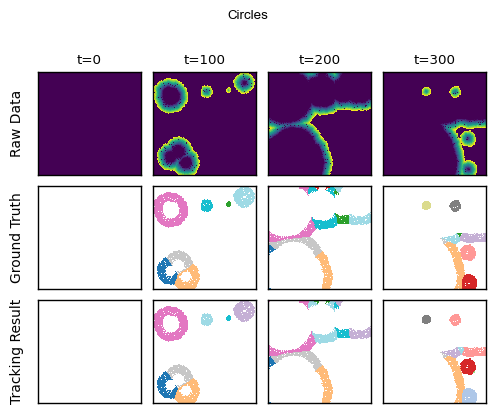

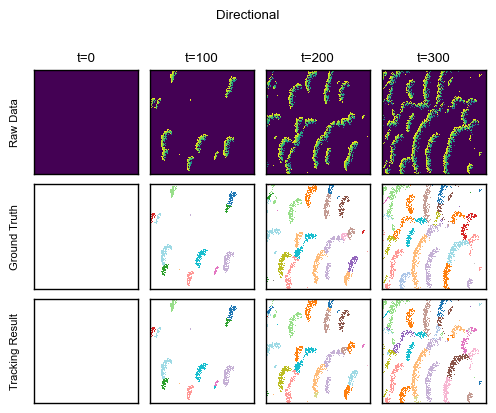

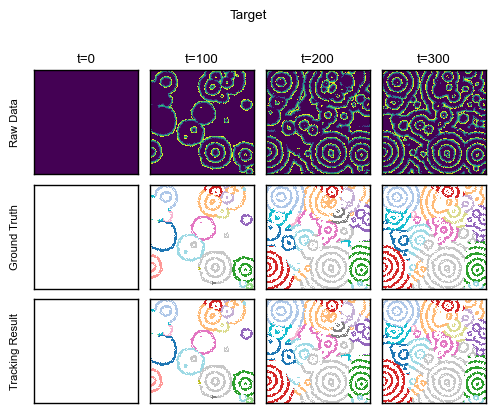

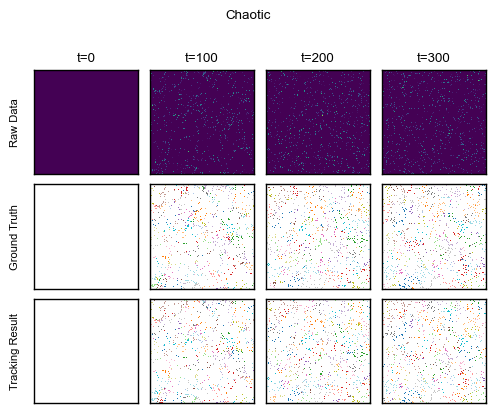

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import matplotlib

# set default theme
plt.style.use('default')

# Define simulation types and their display names
sim_types = ['sim_circles', 'sim_directional', 'sim_target_pattern', 'sim_chaotic']
sim_names = ['Circles', 'Directional', 'Target', 'Chaotic']
frames = [0, 100, 200, 300]

def create_single_simulation_plot(sim_type, sim_name, run_folder, frames):
    # Create figure with 3 rows and len(frames) columns
    fig, axs = plt.subplots(3, len(frames), figsize=(5, 4))
    
    # Update plot parameters
    plt.rcParams.update({
        'svg.fonttype': 'none',
        'font.style': 'normal',
        'font.size': 8,
        'font.family': 'Arial'
    })
    
    colormap = plt.cm.tab20
    
    # Load paths for SNR infinity
    raw_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_inf/00_GT/RAW"
    gt_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_inf/00_GT/TRA"
    tracked_path = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}/{sim_type}_snr_inf/00_RES"
    
    raw_files = sorted([f for f in os.listdir(raw_path) if f.endswith('.tif')])
    gt_files = sorted([f for f in os.listdir(gt_path) if f.endswith('.tif')])
    tracked_files = sorted([f for f in os.listdir(tracked_path) if f.endswith('.tif')])
    
    for frame_idx, frame_num in enumerate(frames):
        # Load frame data
        raw_array = io.imread(os.path.join(raw_path, raw_files[frame_num]))
        gt_array = io.imread(os.path.join(gt_path, gt_files[frame_num]))
        tracked_array = io.imread(os.path.join(tracked_path, tracked_files[frame_num]))
        
        # Normalize RAW data
        raw_norm = (raw_array - raw_array.min()) / (raw_array.max() - raw_array.min())
        
        # Create color mapping
        max_val = max(tracked_array.max(), gt_array.max())
        np.random.seed(0)
        mapping = np.random.choice(np.arange(0, 20), max_val + 1)
        mapping = np.asarray(colormap.colors)[mapping.flatten().astype(int)]
        mapping = np.insert(mapping, 0, [1, 1, 1], axis=0)
        custom_cmap = matplotlib.colors.ListedColormap(mapping)
        
        # Plot data
        axs[0, frame_idx].imshow(raw_norm, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        axs[1, frame_idx].imshow(gt_array, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
        axs[2, frame_idx].imshow(tracked_array, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
        
        # Set title for top row
        axs[0, frame_idx].set_title(f't={frame_num}')
    
    # Set row labels
    row_labels = ['Raw Data', 'Ground Truth', 'Tracking Result']
    for i, label in enumerate(row_labels):
        axs[i, 0].set_ylabel(label, rotation=90, labelpad=10)
    
    # Remove ticks and set spine width for all subplots
    for ax_row in axs:
        for ax in ax_row:
            ax.tick_params(axis='both', which='both', bottom=False, top=False,
                          labelbottom=False, right=False, left=False, labelleft=False)
            for spine in ax.spines.values():
                spine.set_linewidth(1)
    
    plt.suptitle(sim_name, y=1.02)
    plt.tight_layout()
    
    # Save the plot
    os.makedirs(os.path.join(run_folder, 'plots'), exist_ok=True)
    output_path = os.path.join(run_folder, 'plots', f'{sim_type}_frames_comparison.svg')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    # plt.close(fig)

# Create a plot for each simulation type
run_folder = "evaluation_arcospx_run24"
for sim_type, sim_name in zip(sim_types, sim_names):
    create_single_simulation_plot(sim_type, sim_name, run_folder, frames)
    print(f"Completed plot for {sim_name}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import dask.array as da
import os
import matplotlib
import matplotlib.animation as animation

# Update the plot parameters
plt.rcParams.update({'svg.fonttype': 'none'})
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.size': 16})

colormap = matplotlib.colormaps["tab20"]

for sim_type, sim_name in zip(['sim_circles', 'sim_directional', 'sim_target_pattern', 'sim_chaotic'], ['inf', '25.0', '0.0', '-5.0', '-10.0', '-15.0']):
    res_path  = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}_snr_{sim_type}/00_RES"
    tra_path  = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}_snr_{sim_type}/00_GT/TRA"
    raw_path  = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{run_folder}_snr_{sim_type}/00_GT/RAW"

    res_files = sorted([f for f in os.listdir(res_path) if f.endswith('.tif')])
    tra_files = sorted([f for f in os.listdir(tra_path) if f.endswith('.tif')])

    arrays_res = np.stack([io.imread(os.path.join(res_path, f)) for f in res_files])
    arrays_tra = np.stack([io.imread(os.path.join(tra_path, f)) for f in tra_files])

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    max_val = max(arrays_res.max(), arrays_tra.max())

    # Create random color mapping with tab20 colormap for every value up to max_val
    np.random.seed(0)
    mapping = np.random.choice(np.arange(0, 20), max_val + 1)
    mapping = np.asarray(colormap.colors)[mapping.flatten().astype(int)]

    mapping = np.insert(mapping, 0, [1, 1, 1], axis=0)

    custom_cmap = matplotlib.colors.ListedColormap(mapping)

    # Initialize the images with the first frame
    img_tra = axs[0].imshow(arrays_tra[0], cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
    img_res = axs[1].imshow(arrays_res[0], cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=max_val)
    axs[0].set_title('Simulated GT')
    axs[1].set_title('Tracked')
    # fig.set_tight_layout(True)
    # Disable ticks
    for ax in axs:
        ax.tick_params(axis='both', which='both', bottom=False, top=False, 
                       labelbottom=False, right=False, left=False, labelleft=False)
        
    # set axis line width
    for ax in axs:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)

    # Update function for animation
    def update(frame):
        img_tra.set_data(arrays_tra[frame])
        img_res.set_data(arrays_res[frame])
        fig.suptitle(f'{sim_name} Simulation - Frame {str(frame).zfill(3)}')
        return [img_tra, img_res, axs[0].title]

    # Use blit=True for faster animation
    ani = animation.FuncAnimation(fig, update, frames=len(arrays_tra), blit=True)

    # display update callback with cycle time and clear output
    from IPython.display import display, clear_output

    def update_callback(i, n):
        clear_output(wait=True)
        display(f'Frame {i}/{n}')

    output_path = f'{run_folder}/movies/{sim_type}_movie_larger.mp4'
    ani.save(output_path, dpi=300, writer='ffmpeg', fps=60, progress_callback=update_callback)

    # plt.close(fig)
    plt.show()


In [ ]:
import napari
viewer = napari.Viewer()
viewer.add_labels(arrays_res, name='sim_target_pattern_res', blending='additive')
viewer.add_labels(arrays_tra, name='sim_target_pattern_tra', blending='additive')

In [6]:
cluster_sizes = {0: 5, 1: 10, 2: 20, 3: 30, 4: 40, 5: 50, 6: 60, 7: 70, 8: 80, 9: 90}

cluster_size = pd.DataFrame([cluster_sizes]).T.rename(columns={0: 'cluster_size'}).reset_index().rename(columns={'index': 'sequence'})

In [ ]:
from skimage import io
import dask.array as da
from dask import delayed
import os
import numpy as np
import napari

selected_folder = f'{run_folder}/sim_directional_snr_25.0'
sequence = "00"

delayed_read = delayed(io.imread)

path  = f"{selected_folder}/{sequence}_RES"
files = os.listdir(path)
files = [f for f in files if f.endswith('.tif')]
files.sort()

# load all images as dask arrays
lazy_values = [delayed_read(os.path.join(path, f)) for f in files]
arrays_res = np.stack([da.from_delayed(lazy_value, shape=(512, 512), dtype='uint16') for lazy_value in lazy_values])

path  = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{selected_folder}/{sequence}_GT/TRA"
files = os.listdir(path)
files = [f for f in files if f.endswith('.tif')]
files.sort()

# load all images as dask arrays
lazy_values = [delayed_read(os.path.join(path, f)) for f in files]
arrays_tra = np.stack([da.from_delayed(lazy_value, shape=(512, 512), dtype='uint16') for lazy_value in lazy_values])

path  = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{selected_folder}/{sequence}_GT/RAW"
files = os.listdir(path)
files = [f for f in files if f.endswith('.tif')]
files.sort()

lazy_values = [delayed_read(os.path.join(path, f)) for f in files]
arrays_raw = np.stack([da.from_delayed(lazy_value, shape=(512, 512), dtype='uint16') for lazy_value in lazy_values])

viewer = napari.Viewer()
viewer.add_image(arrays_raw, name='sim_circles_raw')
viewer.add_labels(arrays_res, name='sim_circles_res', blending='additive')
viewer.add_labels(arrays_tra, name='sim_circles_tra', blending='additive')

In [47]:
import pandas as pd
import re
from pathlib import Path

file = "summary_bbox_05iou.csv"

def load_summaries(base_path):
    base_path = Path(base_path)
    summary_data = []

    # Define regex pattern for SNR and type extraction
    pattern = re.compile(r'sim_(chaotic|circles|directional|target_pattern)_snr_([\-]?[0-9]+(?:\.[0-9]*)?|inf)')

    # Loop through directories
    for folder in base_path.iterdir():
        if folder.is_dir():
            match = pattern.match(folder.name)
            if match:
                sim_type, snr = match.groups()
                print(sim_type, snr)

                # Path to summary file
                summary_file = folder / file
                if summary_file.exists():
                    print(summary_file)
                    # Load the summary file into a DataFrame
                    df = pd.read_csv(summary_file)

                    # Add 'snr' and 'type' columns
                    df['snr'] = float(snr) if snr != 'inf' else float('inf')
                    df['sim_type'] = sim_type

                    # remove last row
                    # df = df.iloc[:-1]

                    # raname unnamed to sequence
                    df = df.rename(columns={'Unnamed: 0': 'sequence'})

                    summary_data.append(df)
                    if sim_type =="chaotic" and snr == -5.0:
                        print(df)

    # Combine all summaries into a single DataFrame
    combined_df = pd.concat(summary_data, ignore_index=True)
    
    return combined_df

# Example usage
base_path = run_folder
df_mota = load_summaries(base_path)

chaotic -10.0
evaluation_arcospx_run24\sim_chaotic_snr_-10.0\summary_bbox_05iou.csv
chaotic -15.0
evaluation_arcospx_run24\sim_chaotic_snr_-15.0\summary_bbox_05iou.csv
chaotic -5.0
evaluation_arcospx_run24\sim_chaotic_snr_-5.0\summary_bbox_05iou.csv
chaotic 0.0
evaluation_arcospx_run24\sim_chaotic_snr_0.0\summary_bbox_05iou.csv
chaotic 25.0
evaluation_arcospx_run24\sim_chaotic_snr_25.0\summary_bbox_05iou.csv
chaotic inf
evaluation_arcospx_run24\sim_chaotic_snr_inf\summary_bbox_05iou.csv
circles -10.0
evaluation_arcospx_run24\sim_circles_snr_-10.0\summary_bbox_05iou.csv
circles -15.0
evaluation_arcospx_run24\sim_circles_snr_-15.0\summary_bbox_05iou.csv
circles -5.0
evaluation_arcospx_run24\sim_circles_snr_-5.0\summary_bbox_05iou.csv
circles 0.0
evaluation_arcospx_run24\sim_circles_snr_0.0\summary_bbox_05iou.csv
circles 25.0
evaluation_arcospx_run24\sim_circles_snr_25.0\summary_bbox_05iou.csv
circles inf
evaluation_arcospx_run24\sim_circles_snr_inf\summary_bbox_05iou.csv
directional -10.

In [48]:
# Melt the dataframe to make it suitable for seaborn's barplot
df_melted = pd.melt(df_mota, id_vars=['sim_type', 'snr'], value_vars=['mota', 'motp', 'precision', 'recall'], 
                    var_name='Metric', value_name='Value')

In [5]:
##find

In [49]:
df_melted.query("sim_type == 'circles'").snr.unique()

array([-10., -15.,  -5.,   0.,  25.,  inf])

In [50]:
# find nan values in the dataframe
df_melted[df_melted.isna().any(axis=1)]


,sim_type,snr,Metric,Value
250,chaotic,-15.0,motp,NaN
255,chaotic,-15.0,motp,NaN
259,chaotic,-15.0,motp,NaN
310,circles,-15.0,motp,NaN
312,circles,-15.0,motp,NaN
313,circles,-15.0,motp,NaN
315,circles,-15.0,motp,NaN
316,circles,-15.0,motp,NaN
317,circles,-15.0,motp,NaN
319,circles,-15.0,motp,NaN


In [51]:
df_melted.query("sim_type == 'target_pattern' and snr == 25")

,sim_type,snr,Metric,Value
220,target_pattern,25.0,mota,0.823465
221,target_pattern,25.0,mota,0.545009
222,target_pattern,25.0,mota,0.596975
223,target_pattern,25.0,mota,0.352194
224,target_pattern,25.0,mota,0.564704
225,target_pattern,25.0,mota,0.713081
226,target_pattern,25.0,mota,0.783680
227,target_pattern,25.0,mota,0.622952
228,target_pattern,25.0,mota,0.694970
229,target_pattern,25.0,mota,0.675791


In [52]:
df_melted

,sim_type,snr,Metric,Value
0,chaotic,-10.0,mota,-0.051146
1,chaotic,-10.0,mota,-0.032264
2,chaotic,-10.0,mota,-0.045799
3,chaotic,-10.0,mota,-0.037796
4,chaotic,-10.0,mota,-0.036563
...,...,...,...,...
955,target_pattern,inf,recall,0.922551
956,target_pattern,inf,recall,0.956828
957,target_pattern,inf,recall,0.961764
958,target_pattern,inf,recall,0.965875


In [53]:
df = df_melted

C:\Users\benig\AppData\Local\Temp\ipykernel_73240\2644676670.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(['Metric', 'sim_type', 'snr_str']).mean().reset_index()


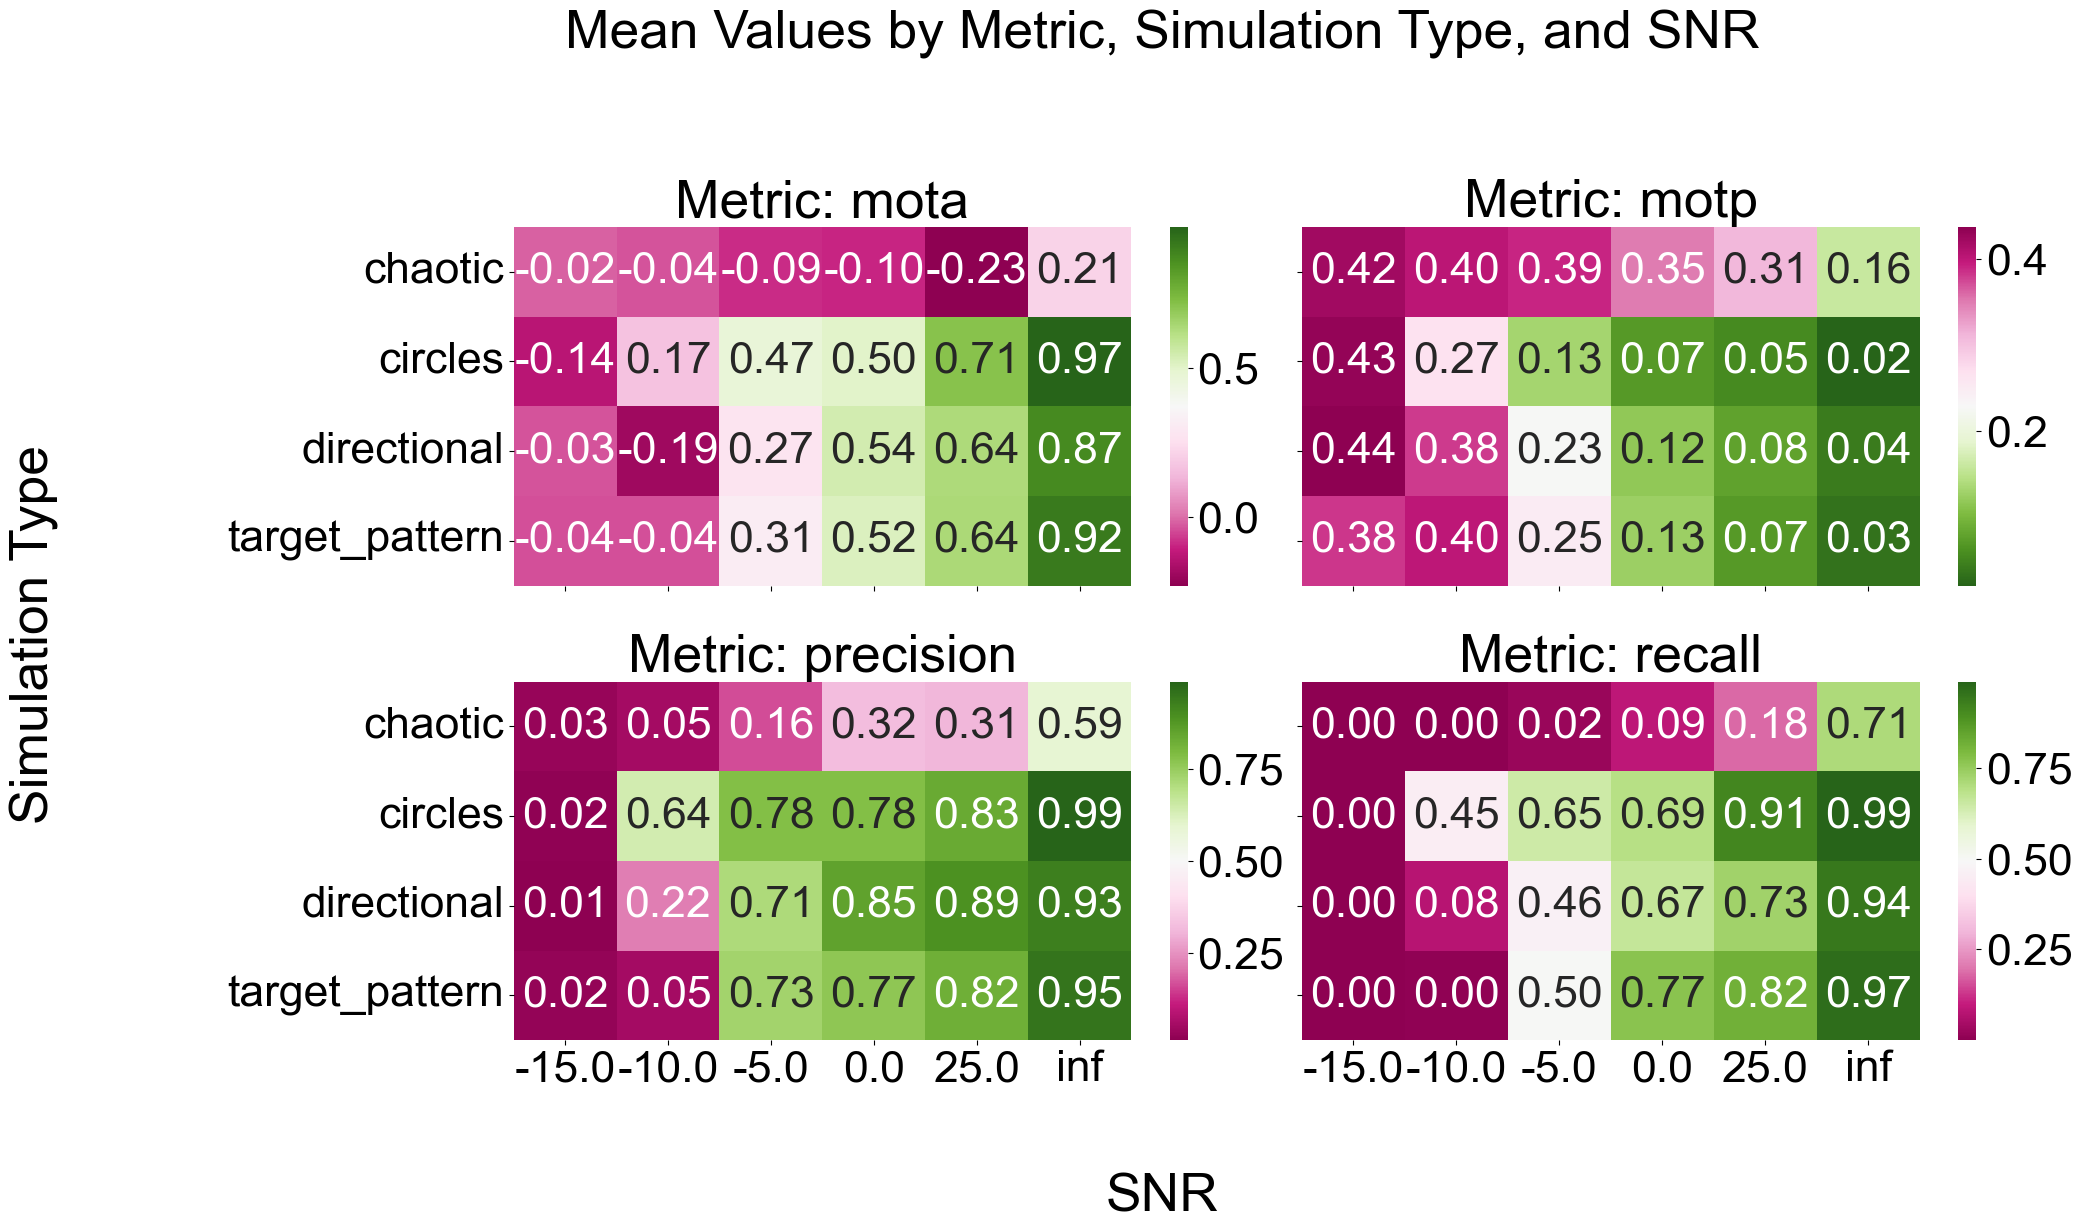

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'df' is your DataFrame
# reset rcParams
plt.rcParams.update(plt.rcParamsDefault)
# set font to Arial
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 32,
    'svg.fonttype': 'none',
    'font.style': 'normal',
})

# Set the style
# plt.style.use('dark_background')


# Step 1: Data Preparation
# ------------------------

# Handle 'inf' in 'snr' and convert to strings
df['snr'] = df['snr'].replace('inf', np.inf)
df['snr'] = pd.to_numeric(df['snr'], errors='coerce')
df['snr_str'] = df['snr'].apply(lambda x: 'inf' if np.isinf(x) else str(x))

# Ensure 'snr_str' is ordered correctly
snr_order_numeric = df['snr'].drop_duplicates().sort_values()
snr_order = [str(s) if not np.isinf(s) else 'inf' for s in snr_order_numeric]
df['snr_str'] = pd.Categorical(df['snr_str'], categories=snr_order, ordered=True)

# Compute mean values
df_mean = df.groupby(['Metric', 'sim_type', 'snr_str']).mean().reset_index()

# Step 2: Plotting with FacetGrid and map_dataframe
# -------------------------------------------------

# Define the custom plotting function
def custom_heatmap(data, **kwargs):
    if data['Metric'].iloc[0] != 'motp':
        cmap = 'PiYG'
    else:
        # invert PiYG colormap for motp
        cmap = 'PiYG_r'

    # Pivot the data
    pivot_table = data.pivot(index='sim_type', columns='snr_str', values='Value')
    
    # Create the heatmap
    sns.heatmap(
        pivot_table,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        **kwargs
    )

# Create the FacetGrid
g = sns.FacetGrid(
    df_mean,
    col='Metric',
    col_wrap=2,  # Adjust as needed
    height=6,
    aspect=2,
    despine=False,
)

# Create a colorbar axis
fig = g.fig
axes = g.axes.flatten()

# Map the custom plotting function
for ax, (_, data) in zip(axes, df_mean.groupby('Metric')):
    if data['Metric'].iloc[0] == 'motp':
        data['Value'] = data['Value']
        metric_name = 'motp'
    else:
        metric_name = data['Metric'].iloc[0]
    custom_heatmap(data, ax=ax)
    ax.set_title(f"Metric: {metric_name}")
    ax.set_xlabel(None)
    ax.set_ylabel(None)


fig.suptitle('Mean Values by Metric, Simulation Type, and SNR', y=1.02)

fig.supylabel('Simulation Type')
fig.supxlabel('SNR')

# Adjust layout
plt.tight_layout(rect=[0.05, 0, 0.9, 1])  # Leave space for colorbar
plt.savefig(f'{run_folder}/plots/heatmap_mean_values_dark.svg', dpi=300)
plt.show()


In [ ]:
from topsis import topsis


# Prepare the decision matrix and weights
decision_matrix = df_mota[['mota', 'motp', 'precision', 'recall']].values
weights = [0.4, 0.2, 0.2, 0.2]
criteria = [1, 1, 1, 1]  # 1 for benefit criteria

# Perform TOPSIS
topsis_scores = topsis(decision_matrix, weights, criteria)
df_mota['topsis_score'] = topsis_scores

# Find the best cluster sizes
best_cluster_sizes = df_mota.loc[df_mota.groupby('snr')['topsis_score'].idxmax()]

In [ ]:
# get maximum mota for each simtype and snr with the corresponding cluster size
max_mota = df_mota.groupby(['sim_type', 'snr'])['mota'].idxmax()

df_mota.loc[max_mota]




In [ ]:
max_mota

In [ ]:
plt.figure(figsize=(30, 6))
g = sns.FacetGrid(df_melted.query("Metric == 'recall'"), col='snr', row='sim_type', height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='cluster_size', y='Value')
# add value on top of the bars
# for ax in g.axes.flat:
#     for p in ax.patches:
#         ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.ylim(0, 1)
g.set_xticklabels(rotation=90)

In [ ]:
# df_mota = pd.read_csv(os.path.join(run_folder, "summary.csv"))
# df_celltrack = pd.read_csv(os.path.join(run_folder, "output_measures.csv"))

In [ ]:
# df_mota['sim_type'] = df_mota['Unnamed: 0'].str.split('_', expand=True)[1]
# df_mota['run'] = [i.split('_')[-1] for idx, i in df_mota['Unnamed: 0'].items()]
# df_mota = df_mota.query("run != 'OVERALL'")   
# df_mota['run'] = df_mota['run'].astype(int)

In [ ]:
# df_celltrack.dropna(inplace=True)

In [ ]:
# df_celltrack['sim_type'] = df_celltrack['Run Type'].str.split('_', expand=True)[1]
# df_celltrack.rename(columns={'Sequence': 'run'}, inplace=True)
# df_celltrack['run'] = df_celltrack['run'].astype(int)

In [ ]:
df_mota.head()

In [ ]:
df_celltrack.head()

In [ ]:
df = pd.merge(df_mota, df_celltrack, on=['sim_type', 'run'])

In [ ]:
print(np.count_nonzero(arrays_res[450]).compute())

print(np.count_nonzero(arrays_tra[450]).compute())



In [6]:
df.rename(columns={"DET measure": "DET", "TRA measure": "TRA", "SEG measure": "SEG"}, inplace=True)

In [ ]:
df

In [85]:
# Melt the dataframe to make it suitable for seaborn's barplot
df_melted = pd.melt(df, id_vars=['Run Type', 'Sequence'], value_vars=['DET', 'TRA', 'SEG'], 
                    var_name='Metric', value_name='Value')

In [86]:
import re
pattern = re.compile(r'sim_(chaotic|circles|directional|target_pattern)_snr_([\-]?[0-9]+(?:\.[0-9]*)?|inf)')


In [87]:
df_melted['sim_type'] = df_melted['Run Type'].str.split('_', expand=True)[1]
df_melted['snr'] = df_melted['Run Type'].apply(lambda x: pattern.match(x).groups()[1])

In [ ]:
df_melted

In [94]:
# find the best run for each metric
best_run = df_melted.groupby(['Metric', 'Run Type'])['Value'].idxmax().dropna()
best_run = df_melted.loc[best_run]


In [ ]:
plt.figure(figsize=(30, 6))
g = sns.FacetGrid(df_melted.query("Metric == 'TRA'"), col='sim_type', row='snr', height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x='Sequence', y='Value')
# add value on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
g.set_xticklabels(rotation=90)

In [144]:
from skimage import io
import dask.array as da
from dask import delayed
import os
import numpy as np
import napari

selected_folder = 'evaluation_arcospx_run17/sim_circles_snr_0.0'

delayed_read = delayed(io.imread)

path  = f"{selected_folder}/00_RES"
files = os.listdir(path)
files = [f for f in files if f.endswith('.tif')]
files.sort()

# load all images as dask arrays
lazy_values = [delayed_read(os.path.join(path, f)) for f in files]
arrays_res = np.stack([da.from_delayed(lazy_value, shape=(512, 512), dtype='uint16') for lazy_value in lazy_values])

path  = f"//izbkingston.izb.unibe.ch/imaging.data/bgraedel/arcos_wave_eval/{selected_folder}/00_GT/TRA"
files = os.listdir(path)
files = [f for f in files if f.endswith('.tif')]
files.sort()

# load all images as dask arrays
lazy_values = [delayed_read(os.path.join(path, f)) for f in files]
arrays_tra = np.stack([da.from_delayed(lazy_value, shape=(512, 512), dtype='uint16') for lazy_value in lazy_values])
viewer = napari.Viewer()
viewer.add_labels(arrays_res, name='sim_circles_res', blending='additive')
viewer.add_labels(arrays_tra, name='sim_circles_tra', blending='additive')

In [65]:

df_melted

,sim_type,snr,Metric,Value,snr_str
0,chaotic,-10.0,mota,-0.051146,-10.0
1,chaotic,-10.0,mota,-0.032264,-10.0
2,chaotic,-10.0,mota,-0.045799,-10.0
3,chaotic,-10.0,mota,-0.037796,-10.0
4,chaotic,-10.0,mota,-0.036563,-10.0
...,...,...,...,...,...
955,target_pattern,inf,recall,0.922551,inf
956,target_pattern,inf,recall,0.956828,inf
957,target_pattern,inf,recall,0.961764,inf
958,target_pattern,inf,recall,0.965875,inf


c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same eff

<Figure size 600x400 with 0 Axes>

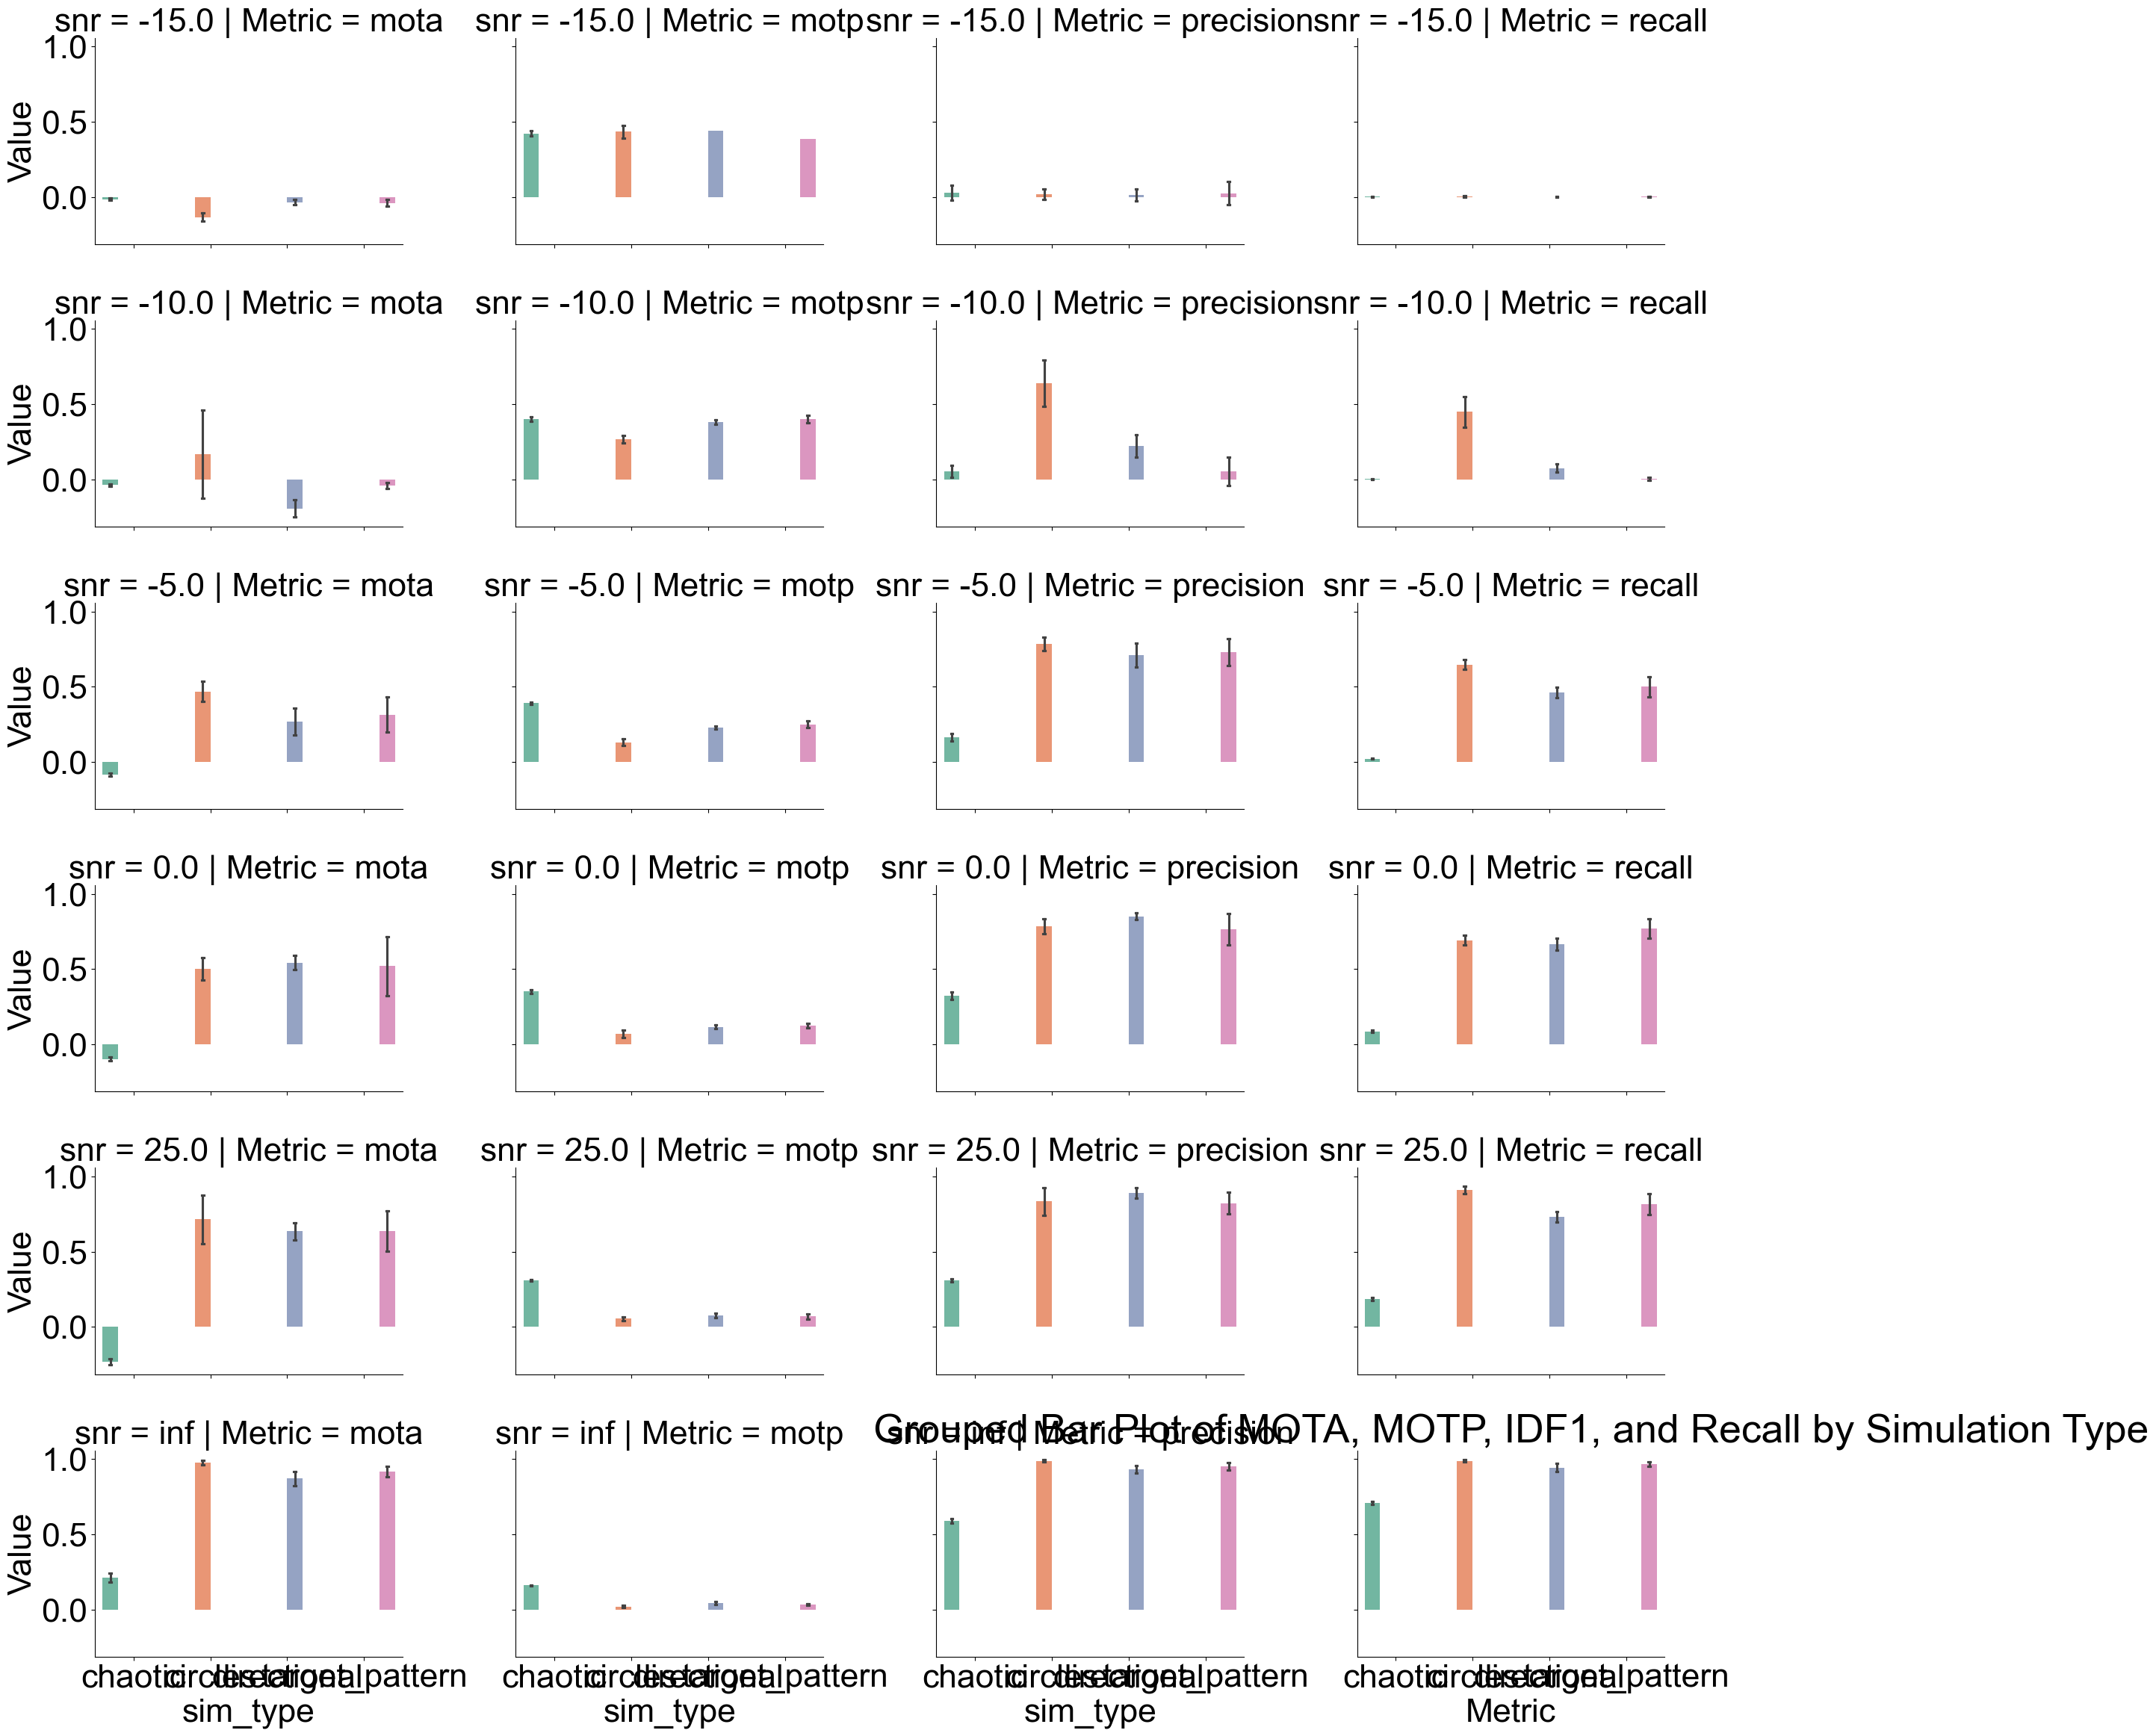

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# # Melt the dataframe to make it suitable for seaborn's barplot
# df_melted = pd.melt(df, id_vars=['sim_type'], value_vars=['mota', 'motp', 'idf1', 'recall', 'DET', 'TRA', 'SEG'], 
#                     var_name='Metric', value_name='Value')

# Plotting the grouped bar plot with dodge by sim_type
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(df_melted, col='Metric', row='snr', height=4, aspect=1.5)
# axes = sns.barplot(data=df_melted, x='Metric', y='Value', hue='sim_type', palette='Set2', dodge=True, errorbar='sd', capsize=0.1)
# put legend to the right outside the plot after adjusting the plot to make room
g.map_dataframe(sns.barplot, x='sim_type', y='Value', palette='Set2', dodge=True, ci='sd', capsize=0.1)



plt.title('Grouped Bar Plot of MOTA, MOTP, IDF1, and Recall by Simulation Type')
plt.ylabel('Metric Value')
plt.xlabel('Metric')
# plt.legend(title='Simulation Type', loc='upper right')
plt.tight_layout()
axes.legend(title='Simulation Type', loc='upper right', bbox_to_anchor=(1.3, 1)) 
plt.savefig(f'{run_folder}/plots/grouped_bar_plot.png', dpi=300)
plt.savefig(f'{run_folder}/plots/grouped_bar_plot.svg', dpi=300)

plt.show()



In [69]:
import pandas as pd
import re
from pathlib import Path

file = "summary_bbox_05iou.csv"

def load_summaries(base_path):
    base_path = Path(base_path)
    summary_data = []

    # Define regex pattern for SNR and type extraction
    pattern = re.compile(r'sim_(chaotic|circles|directional|target_pattern)_snr_([\-]?[0-9]+(?:\.[0-9]*)?|inf)')

    # Loop through directories
    for folder in base_path.iterdir():
        if folder.is_dir():
            match = pattern.match(folder.name)
            if match:
                sim_type, snr = match.groups()
                print(sim_type, snr)

                # Path to summary file
                summary_file = folder / file
                if summary_file.exists():
                    print(summary_file)
                    # Load the summary file into a DataFrame
                    df = pd.read_csv(summary_file)

                    # Add 'snr' and 'type' columns
                    df['snr'] = float(snr) if snr != 'inf' else float('inf')
                    df['sim_type'] = sim_type

                    # remove last row
                    # df = df.iloc[:-1]

                    # raname unnamed to sequence
                    df = df.rename(columns={'Unnamed: 0': 'sequence'})

                    summary_data.append(df)
                    if sim_type =="chaotic" and snr == -5.0:
                        print(df)

    # Combine all summaries into a single DataFrame
    combined_df = pd.concat(summary_data, ignore_index=True)
    
    return combined_df

# Example usage
base_path = run_folder
df_mota = load_summaries(base_path)

chaotic -10.0
evaluation_arcospx_run24\sim_chaotic_snr_-10.0\summary_bbox_05iou.csv
chaotic -15.0
evaluation_arcospx_run24\sim_chaotic_snr_-15.0\summary_bbox_05iou.csv
chaotic -5.0
evaluation_arcospx_run24\sim_chaotic_snr_-5.0\summary_bbox_05iou.csv
chaotic 0.0
evaluation_arcospx_run24\sim_chaotic_snr_0.0\summary_bbox_05iou.csv
chaotic 25.0
evaluation_arcospx_run24\sim_chaotic_snr_25.0\summary_bbox_05iou.csv
chaotic inf
evaluation_arcospx_run24\sim_chaotic_snr_inf\summary_bbox_05iou.csv
circles -10.0
evaluation_arcospx_run24\sim_circles_snr_-10.0\summary_bbox_05iou.csv
circles -15.0
evaluation_arcospx_run24\sim_circles_snr_-15.0\summary_bbox_05iou.csv
circles -5.0
evaluation_arcospx_run24\sim_circles_snr_-5.0\summary_bbox_05iou.csv
circles 0.0
evaluation_arcospx_run24\sim_circles_snr_0.0\summary_bbox_05iou.csv
circles 25.0
evaluation_arcospx_run24\sim_circles_snr_25.0\summary_bbox_05iou.csv
circles inf
evaluation_arcospx_run24\sim_circles_snr_inf\summary_bbox_05iou.csv
directional -10.

In [134]:
df = df_mota

In [135]:
df['relative_false_positives'] = df['num_false_positives'] / df['num_objects'] * 100
df['relative_misses'] = df['num_misses'] / df['num_objects'] * 100
df['relative_switches'] = df['num_switches'] / df['num_objects'] * 100
# df['relative_fragmentations'] = df['num_fragmentations'] / df['num_objects'] * 100


In [136]:
df

,sequence,num_frames,mota,motp,num_switches,num_false_positives,num_misses,num_detections,num_objects,num_predictions,precision,recall,snr,sim_type,relative_false_positives,relative_misses,relative_switches
0,9,500,-0.051146,0.419414,0,5843,111427,137,111564,5980,0.022910,0.001228,-10.0,chaotic,5.237353,99.877201,0.000000
1,8,500,-0.032264,0.372666,0,3642,110352,79,110431,3721,0.021231,0.000715,-10.0,chaotic,3.297987,99.928462,0.000000
2,2,500,-0.045799,0.412371,0,5258,112021,122,112143,5380,0.022677,0.001088,-10.0,chaotic,4.688656,99.891210,0.000000
3,3,500,-0.037796,0.421702,0,4329,112779,64,112843,4393,0.014569,0.000567,-10.0,chaotic,3.836304,99.943284,0.000000
4,1,500,-0.036563,0.407516,108,4304,110688,352,111040,4656,0.075601,0.003170,-10.0,chaotic,3.876081,99.682997,0.097262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1,496,0.835860,0.037772,0,938,838,9982,10820,10920,0.914103,0.922551,inf,target_pattern,8.669131,7.744917,0.000000
236,5,499,0.934597,0.034653,0,224,435,9641,10076,9865,0.977293,0.956828,inf,target_pattern,2.223104,4.317189,0.000000
237,4,498,0.927760,0.031706,1,457,515,12954,13469,13411,0.965923,0.961764,inf,target_pattern,3.392976,3.823595,0.007424
238,6,500,0.872206,0.031884,0,947,345,9765,10110,10712,0.911594,0.965875,inf,target_pattern,9.366963,3.412463,0.000000


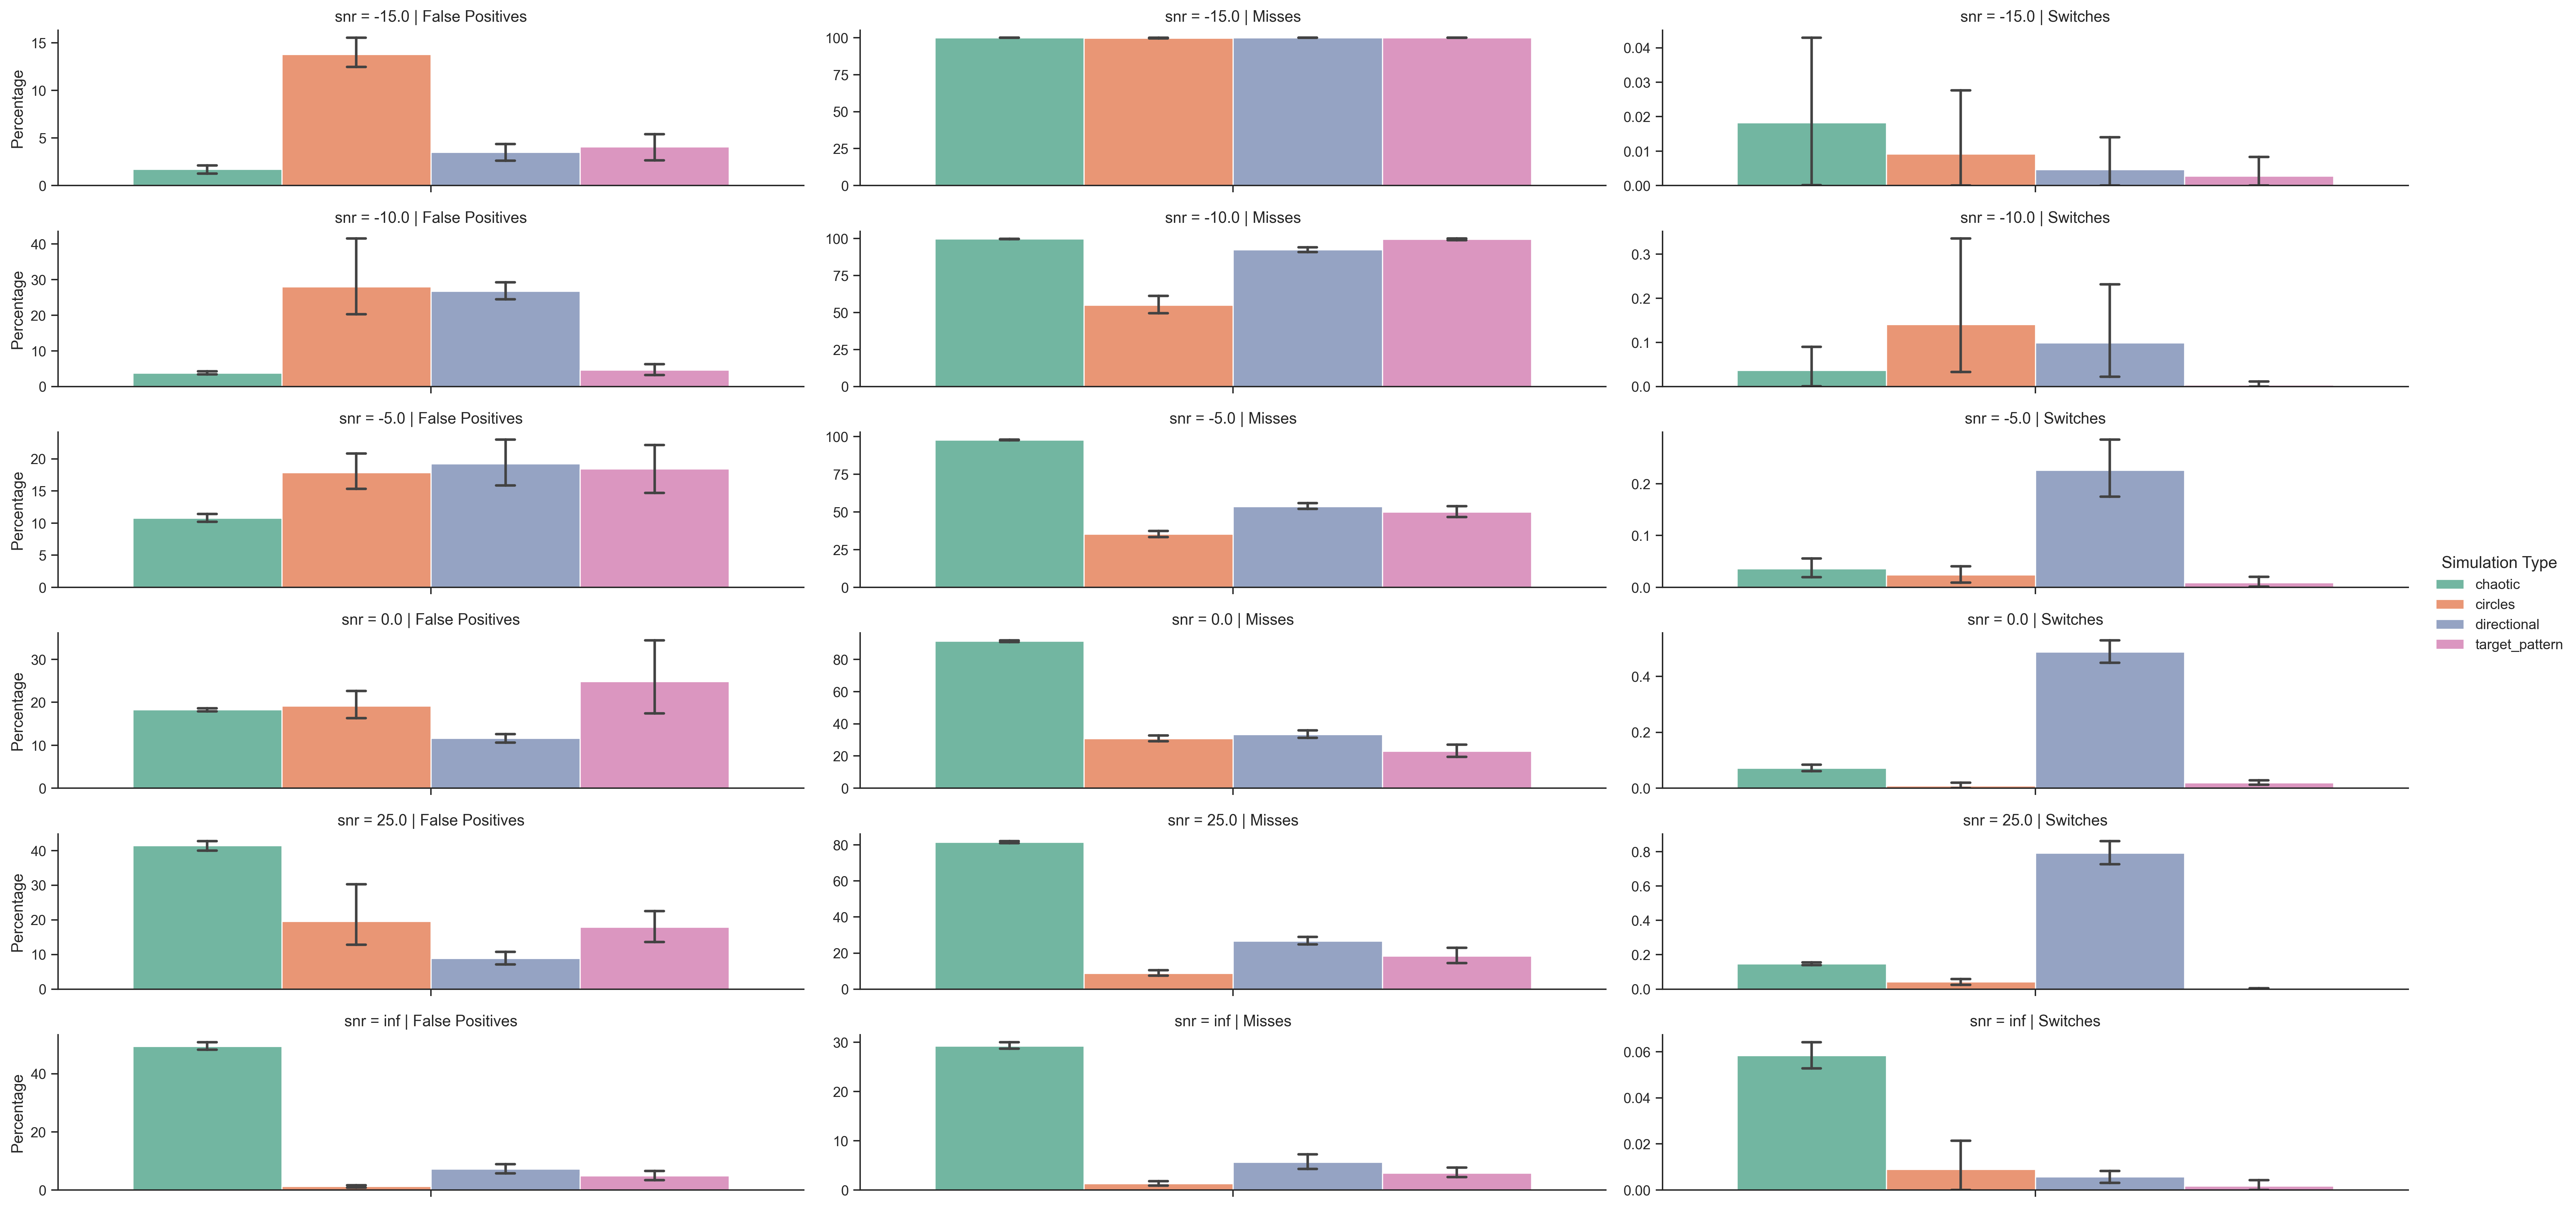

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Melt the dataframe to make it suitable for seaborn's barplot
df_melted = pd.melt(df, id_vars=['sim_type', 'snr'], value_vars=['relative_false_positives', 'relative_misses', 'relative_switches'], 
                    var_name='Metric', value_name='Value')

df_melted.replace({'relative_false_positives': 'False Positives', 'relative_misses': 'Misses', 'relative_switches': 'Switches', 'relative_fragmentations': 'Fragmentations'}, inplace=True)


# Plotting the grouped bar plot with dodge by sim_type
g = sns.catplot(data=df_melted, col='Metric', row='snr', y='Value', hue='sim_type', palette='Set2', kind='bar', dodge=True, errorbar='ci', capsize=0.1, sharey=False, height=2, aspect=4)
# axes = sns.barplot(data=df_melted, x='Metric', y='Value', hue='sim_type', palette='Set2', dodge=True, errorbar='sd', capsize=0.1)
# put legend to the right outside the plot after adjusting the plot to make room

# g.figure.suptitle('Grouped Bar Plot of Relative False Positives, Misses, Switches, and Fragmentations by Simulation Type')
g.set_ylabels('Percentage')
# g.set_titles(col_template=['Relative False Positives', 'Relative Misses', 'Relative Switches', 'Relative Fragmentations'])
g.set_titles(col_template="{col_name}")
# g.set_axis_labels("", "Percentage")
g.legend.set_title('Simulation Type')
# plt.savefig(f'{run_folder}/plots/grouped_bar_plot_relative.png', dpi=300)
# plt.savefig(f'{run_folder}/plots/grouped_bar_plot_relative.svg', dpi=300)

plt.show()


In [140]:
df_melted['snr'].unique()

array([-10., -15.,  -5.,   0.,  25.,  inf])

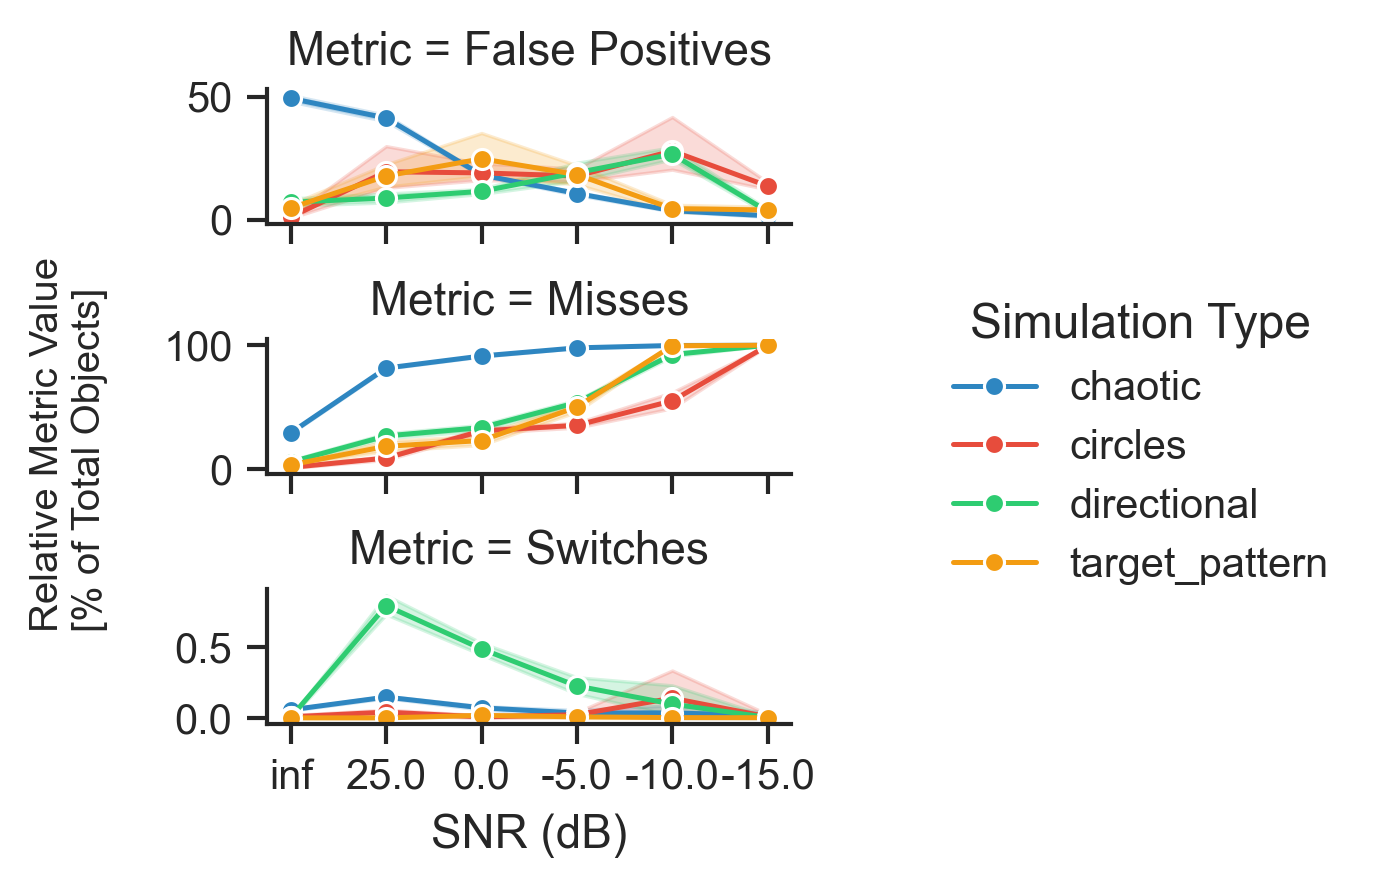

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'svg.fonttype': 'none',
    'font.style': 'normal',
})

# Create mapping of SNR values to numeric order (removing duplicates)
snr_unique = sorted(list(set([x for x in df_melted['snr'].unique() if x != 'inf'])))
snr_map = {snr: idx for idx, snr in enumerate(snr_unique)}

# Create new numeric column for plotting
df_melted['snr_order'] = df_melted['snr'].map(snr_map)

# Create simple figure with clean style
sns.set_style("ticks")
plt.rcParams['font.family'] = 'Arial'

# Create the facet grid
g = sns.FacetGrid(
    df_melted,
    row='Metric',
    sharey=False,
    height=1,
    aspect=1.5
)

# Create the line plots
g.map_dataframe(
    sns.lineplot,
    x='snr_order',
    y='Value',
    hue='sim_type',
    marker='o'
)

# Customize each subplot
for ax in g.axes.flat:
    # Set x-axis ticks and labels
    ax.set_xticks(range(len(snr_unique)))
    ax.set_xticklabels(snr_unique)
    
    # Invert x-axis
    ax.invert_xaxis()
    
    # Remove top and right spines
    sns.despine(ax=ax)

# Add legend and labels
g.add_legend(title='Simulation Type', bbox_to_anchor=(1.05, 0.5), loc='center left')
g.set_axis_labels('SNR (dB)', '')

# Set supylabel
g.figure.supylabel('Relative Metric Value\n[% of Total Objects]')

# Adjust layout
plt.tight_layout()
plt.savefig(f'{run_folder}/plots/line_plot_relative.svg', dpi=300)
plt.show()

In [ ]:
df['sim_type'].unique()

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns

# Assuming 'df' is your DataFrame
metrics = ['mota', 'motp', 'idf1', 'recall', 'DET', 'TRA', 'SEG']  # Adjusted metric names
categories = [f'{metric}' for metric in metrics]  # Adjusted metric names

# Function to plot radar chart
def plot_radar(df, ax, color, label):
    values = [df[f'{metric}'].mean() for metric in metrics]
    values += values[:1]  # Close the loop

    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=label, color=color, alpha=1)
    ax.fill(angles, values, color=color, alpha=0.25)

# Set up the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Use the Set3 color palette
colors = sns.color_palette('tab10', n_colors=len(df['sim_type'].unique()))

# Plot each sim_type on the radar chart
for i, sim_type in enumerate(df['sim_type'].unique()):
    plot_radar(df[df['sim_type'] == sim_type], ax, colors[i], sim_type)

# Customize the radar chart
ax.set_xticks([n / float(len(metrics)) * 2 * pi for n in range(len(metrics))])
ax.set_xticklabels(metrics)
ax.set_yticklabels([])  # Hides the y-axis labels

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Radar Chart of Key Metrics Across Simulation Types')
plt.tight_layout()
plt.savefig(f'{run_folder}/plots/radar_chart.png', dpi=300)
plt.savefig(f'{run_folder}/plots/radar_chart.svg', dpi=300)
plt.show()

KeyError: 'idf1'

In [ ]:
plt.table(font)

In [ ]:
summary_table

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame with relevant columns
# Create a summary table for the key metrics
summary_table = df.groupby('sim_type')[['mota', 'motp', 'idf1', 'recall', 'DET', 'TRA', 'SEG']].mean().reset_index()
summary_table = summary_table.round(10)
# replace sim_type with the actual name of the simulation type
summary_table['sim_type'] = summary_table['sim_type'].replace({'circles': 'Circles', 'directional': 'Directional', 'target': 'Target', 'chaotic': 'Chaotic'})

summary_table.rename(columns={'sim_type': 'Type', 'mota': 'MOTA', 'motp': 'MOTP', 'idf1': 'IDF1', 'recall': 'Recall', 'DET': 'DET', 'TRA': 'TRA', 'SEG': 'SEG'}, inplace=True)
# set fontsize to 8 arial
plt.rcParams.update({'svg.fonttype': 'none'})
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.size': 8})

# Plot the table as an image
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust the size as needed

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False)

# Create the table with custom formatting
table = ax.table(cellText=summary_table.round(2).values, 
                 colLabels=summary_table.columns, 
                 cellLoc='center', 
                 loc='center', 
                 colColours=['#f7f7f7']*summary_table.shape[1],
                 fontsize=8)  # Add column background color

# Enhance table appearance
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)  # Adjust scaling if necessary

# Adjust the cell borders and colors
for key, cell in table.get_celld().items():
    cell.set_linewidth(1.5)  # Set border thickness
    cell.set_edgecolor('#4f4f4f')  # Set border color
    if key[0] == 0:
        cell.set_text_props(weight='bold', color='#333333')  # Header text style
        cell.set_facecolor('#dcdcdc')  # Header background color
    else:
        cell.set_facecolor('#f7f7f7')  # Cell background color
plt.tight_layout()
# Save as an image file
# plt.savefig(f'{run_folder}/summary_table_metrics.png', dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig(f'{run_folder}/summary_table_metrics.svg', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Set up the figure size and styling
plt.figure(figsize=(14, 12))
sns.set_theme(style="white")

# Generate a mask for the upper triangle (optional, to make the heatmap less cluttered)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .75},
            annot_kws={"size": 12},  # Increase annotation size
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns,  # Explicitly set labels
            )

# Adjust the labels and layout for better clarity
plt.title('Correlation Matrix of Performance Metrics', size=16)
plt.xticks(rotation=90, ha='right', fontsize=12)  # Rotate x labels for better alignment
plt.yticks(fontsize=12)  # Set y-tick label size
# plt.grid(True, which='both', linestyle='-', linewidth=0.5)  # Add grid lines for clarity
plt.tight_layout()

# Save the heatmap as an image
plt.savefig(f'{run_folder}/plots/correlation_heatmap.png', dpi=300)
plt.savefig(f'{run_folder}/plots/correlation_heatmap.svg', dpi=300)

# Display the heatmap
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataset is in a DataFrame `df`
df = pd.read_csv('evaluation_arcospx_run3/output_measures.csv')  # Replace with your actual DataFrame loading

df = df.dropna()

# Melt the DataFrame to long format for plotting
df_melted = pd.melt(df[df['Sequence'] != 'N/A'], id_vars=['Run Type', 'Sequence'], 
                    value_vars=['DET measure', 'TRA measure', 'SEG measure'], 
                    var_name='Metric', value_name='Value')

# Grouped bar plot with 'Run Type' as dodge
plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted, x='Metric', y='Value', hue='Run Type',palette='Set3', dodge=True, errorbar='sd', capsize=0.1)

plt.title('Grouped Bar Plot of DET, TRA, SEG Measures by Simulation Type')
plt.ylabel('Metric Value')
plt.xlabel('Metric')
plt.legend(title='Simulation Type', loc='upper right')
plt.tight_layout()

# Save the plot as an image
plt.savefig(f'{run_folder}/plots/grouped_bar_plot_celltrack_measures.png', dpi=300)
plt.savefig(f'{run_folder}/plots/grouped_bar_plot_celltrack_measures.svg', dpi=300)
plt.show()


In [ ]:
plt.figure(figsize=(14, 8))

# Loop through each metric and plot a line for each simulation type
for metric in ['DET measure', 'TRA measure', 'SEG measure']:
    sns.lineplot(data=df[df['Sequence'] != 'N/A'], x='Sequence', y=metric, hue='Run Type', marker='o')

plt.title('Metrics Across Different Sequences by Simulation Type')
plt.ylabel('Metric Value')
plt.xlabel('Sequence')
plt.legend(title='Simulation Type', loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
from math import pi

# Categories to plot
categories = ['DET measure', 'TRA measure', 'SEG measure']
N = len(categories)

# Radar plot for each simulation type
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

df_avg = df.groupby('Run Type').mean().reset_index()
# Use the Set3 color palette
colors = sns.color_palette('Set3', n_colors=len(df_avg['Run Type'].unique()))

for i, (index, row) in enumerate(df_avg.iterrows()):
    values = row[categories].values.flatten().tolist()
    values += values[:1]  # Close the loop

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Run Type'], color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.25)

# Customize the radar chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_yticklabels([])  # Hides the y-axis labels

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title('Radar Chart of Average Metrics Across Simulation Types')
plt.tight_layout()

# Save the plot as an image
plt.savefig('radar_chart_celltrack_measures.png', dpi=300)
plt.savefig('radar_chart_celltrack_measures.svg', dpi=300)

plt.show()


In [ ]:
# Compute the correlation matrix for the averages
corr_matrix = df[['DET measure', 'TRA measure', 'SEG measure']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

plt.title('Correlation Matrix of Average Metrics Across Simulation Types')
plt.tight_layout()

# Save the heatmap as an image
plt.savefig('correlation_heatmap_celltrack_measures.png', dpi=300)
plt.savefig('correlation_heatmap_celltrack_measures.svg', dpi=300)
plt.show()
